<a href="https://colab.research.google.com/github/tingyi16988/Financial-Analytics-ARIMA/blob/colab/_financial_analytics_ca_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the required packages**


Here, we import the code-required libraries. ARIMA is a class in the statsmodels library that implements the ARIMA time series model, and mean_squared_error is a function from the sklearn library that we will use to assess the effectiveness of the model. The other libraries are pandas for data manipulation and analysis, numpy for scientific computing, matplotlib for plotting, and statsmodels for statistical modeling.

In [ ]:
!pip install pmdarima
!pip3 install arch yfinance pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.1/920.1 kB 8.3 MB/s eta 0:00:00


**Download the data**


Download the S&P 500 stock price from Yahoo Finance.

Start date: 01 January, 2018


End date: 31 December, 2021

In [ ]:
ticker = '^GSPC'
stock_data = yf.download(ticker, start="2018-01-01", end="2021-12-31")
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000
...,...,...,...,...,...,...
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000


**Visualization**


Visualize the stock’s daily closing price.

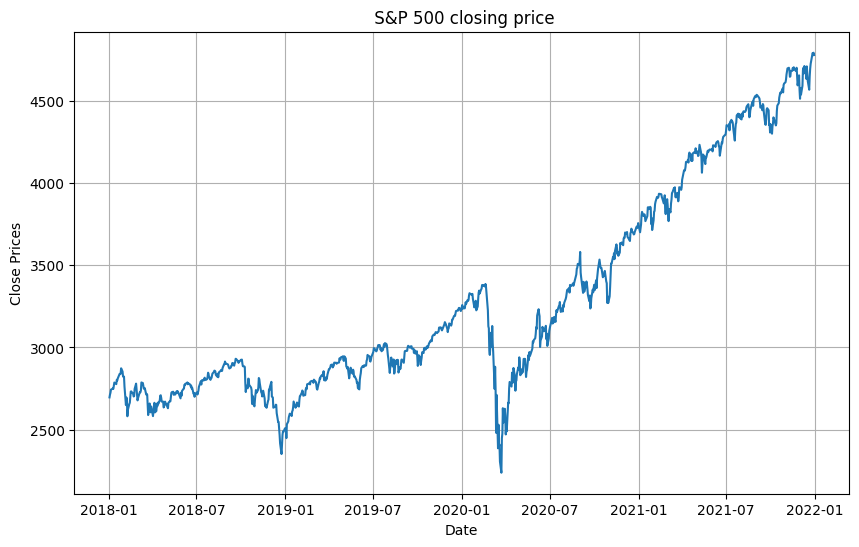

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title(' S&P 500 closing price')
plt.show()

**Distribution graph**


Use probability distribution to visualize the data in our series.

<Axes: ylabel='Density'>

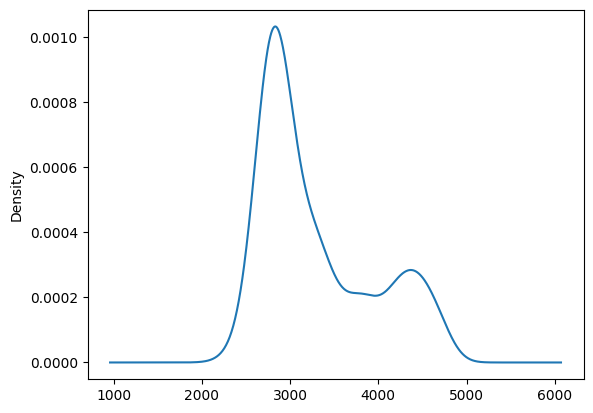

In [ ]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

**ADF (Augmented Dickey-Fuller) Test**


One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

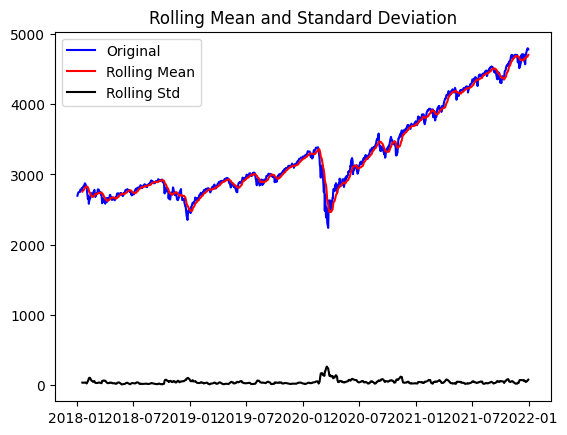

Results of dickey fuller test
Test Statistics                  0.367719
p-value                          0.980247
No. of lags used                 9.000000
Number of observations used    997.000000
critical value (1%)             -3.436926
critical value (5%)             -2.864443
critical value (10%)            -2.568316
dtype: float64


In [ ]:
#Test for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

**isolate the time series from the Trend and Seasonality**


To separate the trend and the seasonality from a time series,
we can decompose the series using the following code.

<Figure size 640x480 with 0 Axes>

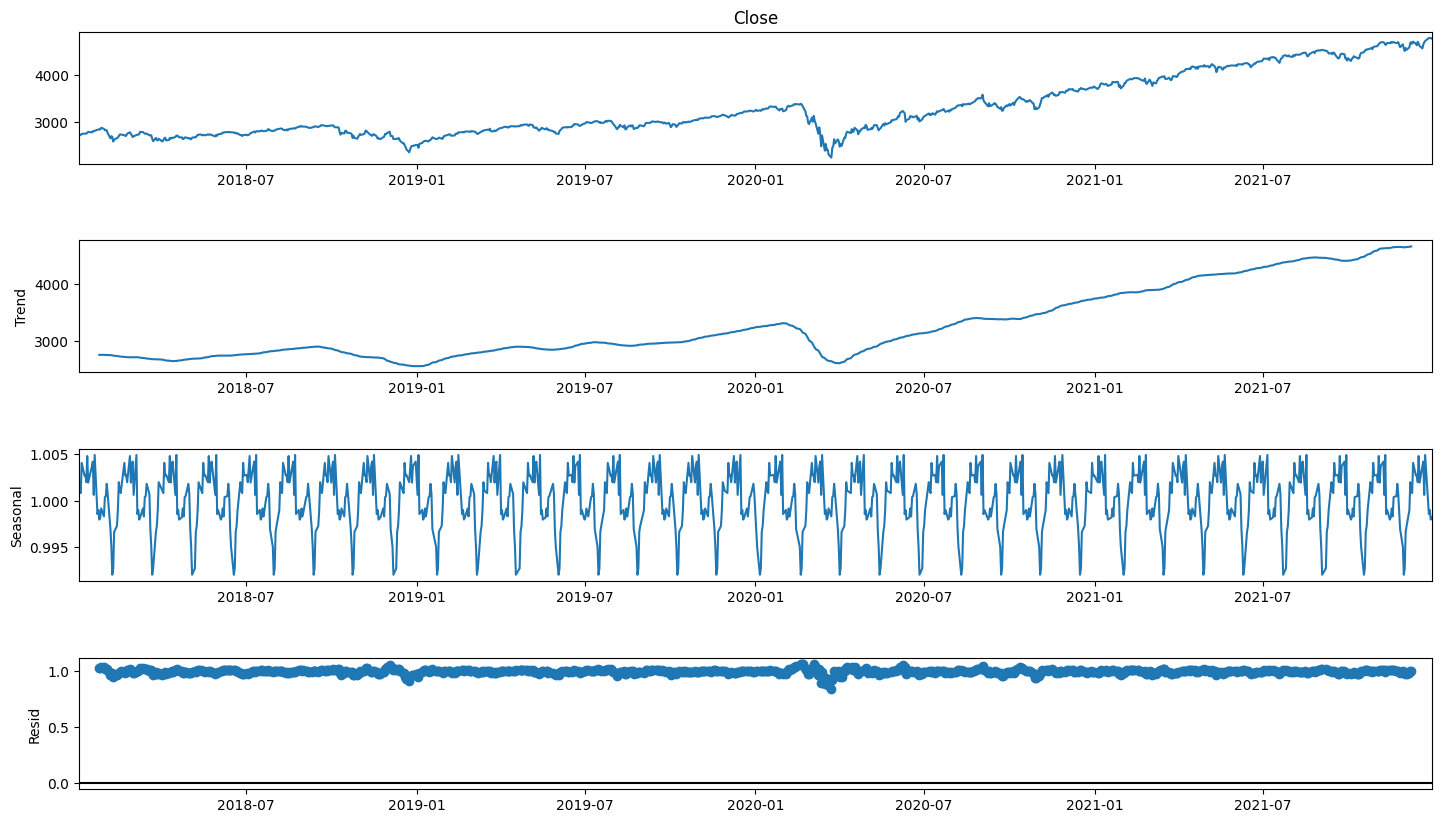

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)


**Eliminate trend**

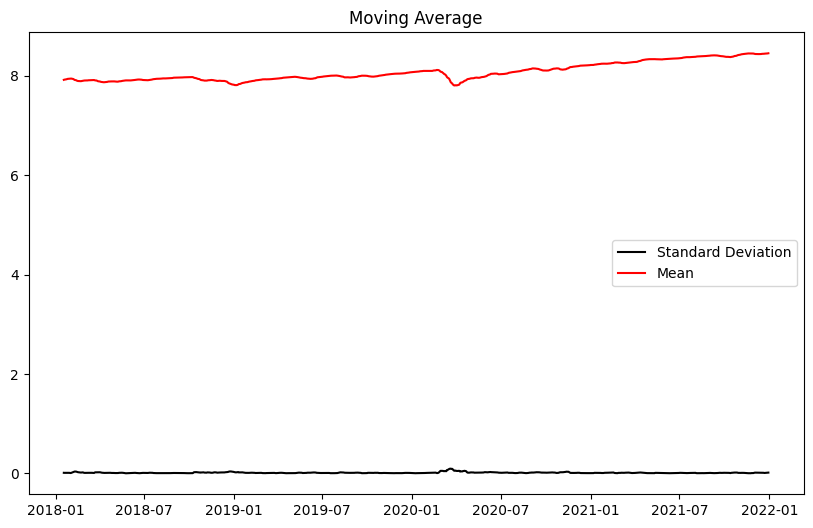

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

**Differencing**

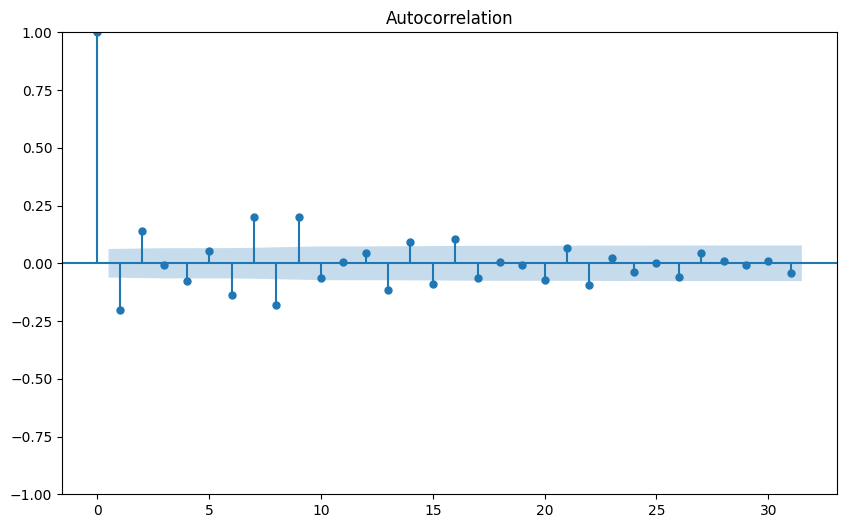

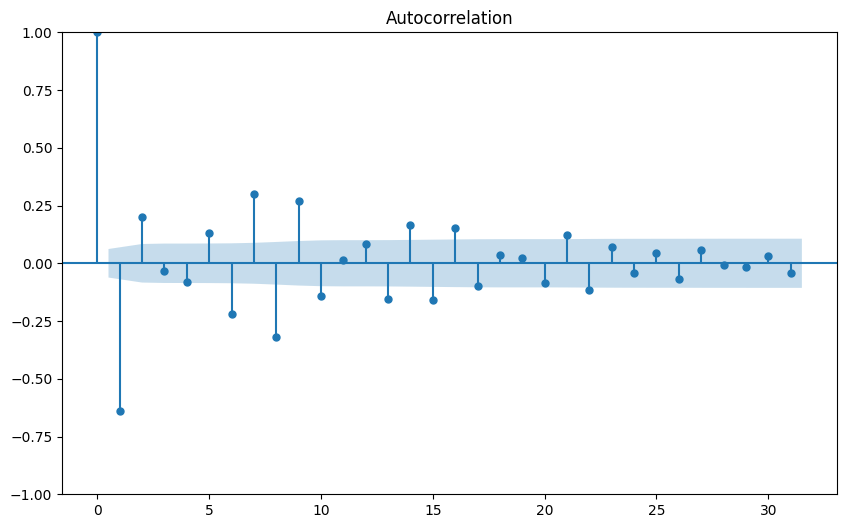

In [ ]:
stock_data["1st_diff"] = stock_data["Close"].diff()
stock_data["2nd_diff"] = stock_data["1st_diff"].diff()

fig = make_subplots(rows=2, cols=1)

for idx, d in enumerate(["1st_diff", "2nd_diff"]):
    fig.add_trace(
        go.Scatter(
            name = d,
            x = stock_data.index,
            y = stock_data[d]
        ),
        row=idx+1,col=1
    )
fig.update_layout(
    title="Differenced plots"
)
fig.show()

plot_acf(stock_data["1st_diff"].dropna())
plot_acf(stock_data["2nd_diff"].dropna());

In [ ]:
print(stock_data)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-01-02  2683.729980  2695.889893  2682.360107  2695.810059  2695.810059   
2018-01-03  2697.850098  2714.370117  2697.770020  2713.060059  2713.060059   
2018-01-04  2719.310059  2729.290039  2719.070068  2723.989990  2723.989990   
2018-01-05  2731.330078  2743.449951  2727.919922  2743.149902  2743.149902   
2018-01-08  2742.669922  2748.510010  2737.600098  2747.709961  2747.709961   
...                 ...          ...          ...          ...          ...   
2021-12-23  4703.959961  4740.740234  4703.959961  4725.790039  4725.790039   
2021-12-27  4733.990234  4791.490234  4733.990234  4791.189941  4791.189941   
2021-12-28  4795.490234  4807.020020  4780.040039  4786.350098  4786.350098   
2021-12-29  4788.640137  4804.060059  4778.080078  4793.060059  4793.060059   
2021-12-30  4794.229980  4808.930176  4775.330078  4

**Split data into train and training set**

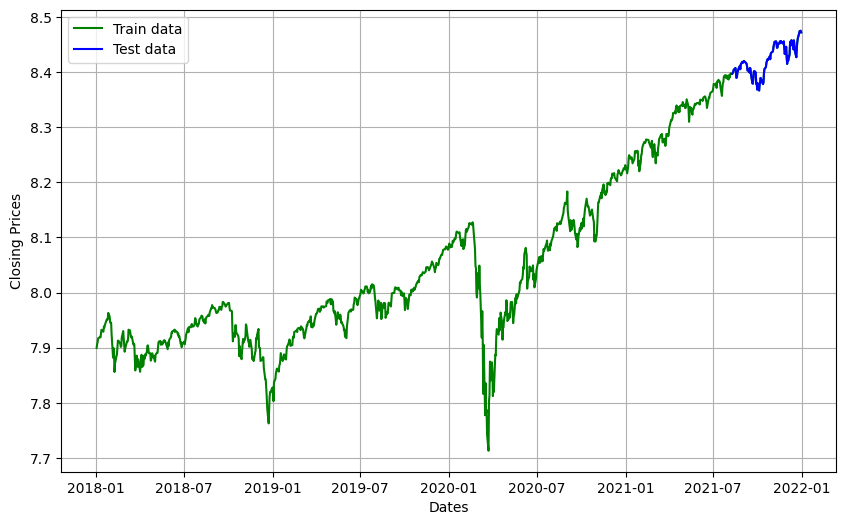

In [ ]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

**Auto ARIMA**

Automatically discover the optimal order for an ARIMA model.

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-4311.263, Time=0.48 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-5081.271, Time=1.45 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-5181.848, Time=2.65 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-4848.771, Time=0.21 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-5179.369, Time=1.30 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-5174.196, Time=4.33 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-4984.009, Time=0.28 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-5155.108, Time=1.33 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-5249.219, Time=2.22 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-5001.706, Time=0.34 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-5160.260, Time=1.89 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.24 sec

Best model:  ARIMA

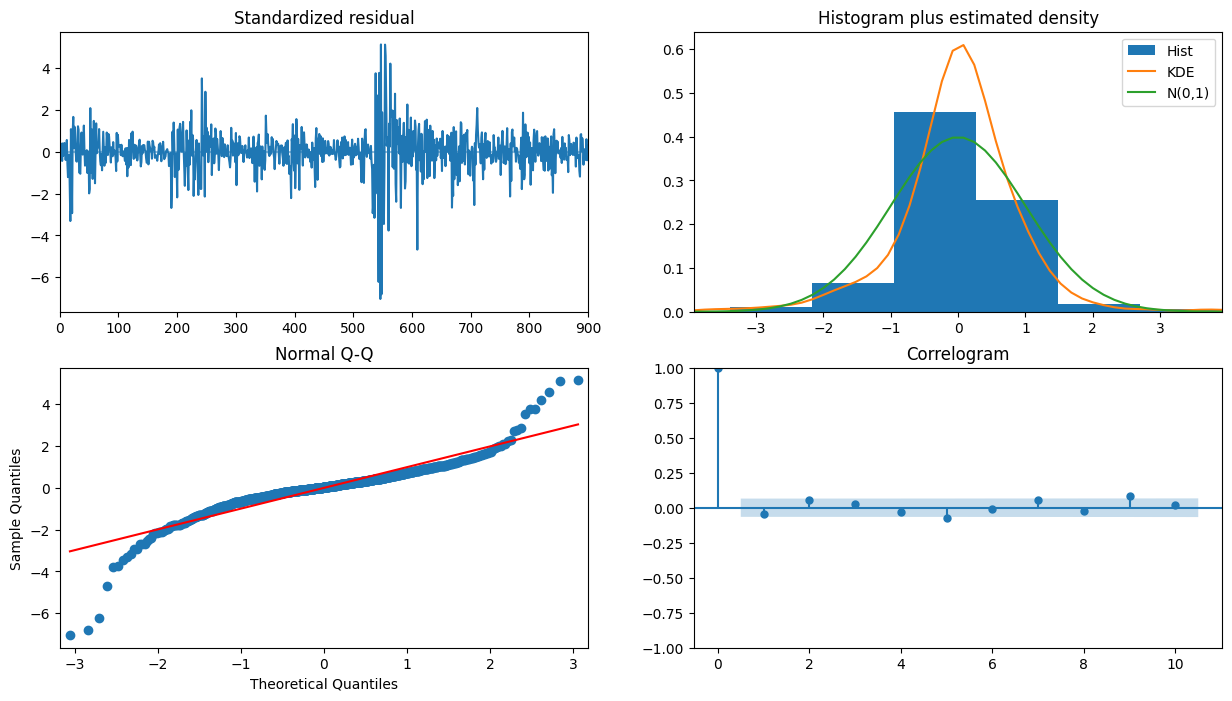

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # determine 'd' 2nd diff
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Build Model**

In [ ]:
import statsmodels.api as sm
model = sm.tsa.ARIMA(train_data, order=(2, 2, 3))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  903
Model:                 ARIMA(2, 2, 3)   Log Likelihood                2633.388
Date:                Thu, 27 Apr 2023   AIC                          -5254.777
Time:                        14:09:46   BIC                          -5225.956
Sample:                             0   HQIC                         -5243.767
                                - 903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7468      0.020    -85.549      0.000      -1.787      -1.707
ar.L2         -0.8662      0.019    -46.067      0.000      -0.903      -0.829
ma.L1          0.6204      0.027     23.028      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



**Forecasting stock prices**

with the accuracy 95% (alpha = 0.05)

In [ ]:
result = fitted.get_forecast(101, alpha =0.05).summary_frame()
print(result)
fc_series = pd.Series(result['mean'].values, index=test_data.index)
lower_series = pd.Series(result['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(result['mean_ci_upper'].values, index=test_data.index)


Close      mean   mean_se  mean_ci_lower  mean_ci_upper
903    8.398738  0.012721       8.373805       8.423670
904    8.400617  0.016891       8.367510       8.433723
905    8.400512  0.020825       8.359695       8.441329
906    8.403208  0.024316       8.355549       8.450867
907    8.402730  0.027038       8.349736       8.455724
...         ...       ...            ...            ...
999    8.508969  0.233472       8.051373       8.966565
1000   8.510116  0.235969       8.047625       8.972606
1001   8.511262  0.238473       8.043863       8.978660
1002   8.512407  0.240985       8.040085       8.984729
1003   8.513554  0.243504       8.036294       8.990814

[101 rows x 4 columns]


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



We are plotting values calculated and stored in the variable fc_series. Following is the plot generated:

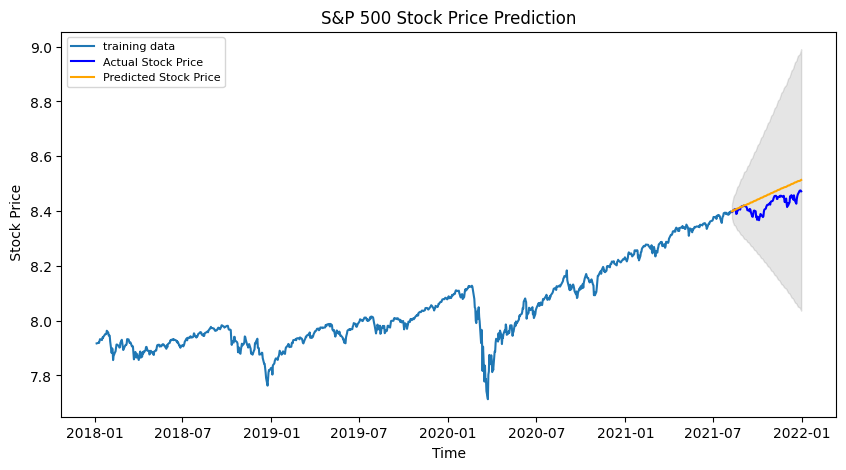

In [ ]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


**Report performance**

In [ ]:
mse = mean_squared_error(test_data, fc_series)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc_series)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc_series - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0017177181812011578
MAE: 0.0350056551980361
RMSE: 0.041445363808285694
MAPE: 0.004157853577132974
